# Testing models on the test set

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd
import numpy as np
import wandb
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from data.shots_data_retriever import ShotsDataRetriever

## Data pre-processing

In [5]:
shotsDataRetriever = ShotsDataRetriever()
season_df = shotsDataRetriever.get_season_df_for_milestone2_test_set()
playoffs_df = shotsDataRetriever.get_playoffs_df_for_milestone2_test_set()

In [7]:
season_df1 = pd.get_dummies(season_df.drop(columns=['game_id', 'play_num']), columns=['shot_type'])
X_season = season_df1.drop(columns=['is_goal'])
y_season = season_df1['is_goal']

playoffs_df1 = pd.get_dummies(playoffs_df.drop(columns=['game_id', 'play_num']), columns=['shot_type'])
X_playoffs = playoffs_df1.drop(columns=['is_goal'])
y_playoffs = playoffs_df1['is_goal']

In [8]:
X_base_distance_season = X_season[['distance']]
X_base_angle_season = X_season[['angle_to_goal']]
X_base_distance_angle_season = X_season[['distance', 'angle_to_goal']]
X_xgboost_v0_season = X_season[['angle_to_goal', 'distance']]
X_xgboost_v1_season = X_season

X_base_distance_playoffs = X_playoffs[['distance']]
X_base_angle_playoffs = X_playoffs[['angle_to_goal']]
X_base_distance_angle_playoffs = X_playoffs[['distance', 'angle_to_goal']]
X_xgboost_v0_playoffs = X_playoffs[['angle_to_goal', 'distance']]
X_xgboost_v1_playoffs = X_playoffs

## Load models

In [9]:
run = wandb.init(project="IFT6758.2024-A02", id="get_models", resume="allow")

# Base models
base_distance_path = run.use_model(name="base_distance:v1")
base_angle_path = run.use_model(name="base_angle:v1")
base_distance_angle_path = run.use_model(name="base_distance_angle:v1")

with open(base_distance_path, 'rb') as f:
    base_distance = pickle.load(f)
with open(base_angle_path, 'rb') as f:
    base_angle = pickle.load(f)
with open(base_distance_angle_path, 'rb') as f:
    base_distance_angle = pickle.load(f)

# XGBoost model
xgboost_v1_path = run.use_model(name="xgboost_v1_model:v0")

with open(xgboost_v1_path, 'rb') as f:
    xgboost_v1 = pickle.load(f)

# Advanced models - Nathan à rajouter
# Pour trouver la version tu dois aller dans la section "artifacts" dans la toolbar à gauche et dérouler ton modèle

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lofeodo (IFT6758-2024-A02). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


## Make predictions and obtain results

In [ ]:
def get_and_log_model_results(id: str, model, X_test, y_test):
    wandb.init(project="IFT6758.2024-A02", id=id, resume="allow")

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    wandb.log({
        "accuracy": accuracy,
        "roc_auc": roc_auc,
    })
    print(f"Accuracy: {accuracy}", f"ROC AUC: {roc_auc}")

    results = pd.DataFrame({
        'goal_proba': y_pred_prob,
        'non_goal_proba': 1 - y_pred_prob,
        'is_goal': y_test
    })
    wandb.log({f"results-{id}": wandb.Table(dataframe=results)})

    wandb.finish()

    return results

### Season results

In [11]:
# Base models
results_base_distance_season = get_and_log_model_results("base_distance-test_set-season", base_distance, X_base_distance_season, y_season)
results_base_angle_season = get_and_log_model_results("base_angle-test_set-season", base_angle, X_base_angle_season, y_season)
results_base_distance_angle_season = get_and_log_model_results("base_distance_angle-test_set-season", base_distance_angle, X_base_distance_angle_season, y_season)

# XGBoost models
results_xgboost_v1_season = get_and_log_model_results("xgboost_v1-test_set-season", xgboost_v1, X_xgboost_v1_season, y_season)

# Advanced models - Nathan à rajouter


NameError: name 'y' is not defined

### Playoffs results

In [ ]:
# Base models
results_base_distance_playoffs = get_and_log_model_results("base_distance-test_set-playoffs", base_distance, X_base_distance_playoffs, y_playoffs)
results_base_angle_playoffs = get_and_log_model_results("base_angle-test_set-playoffs", base_angle, X_base_angle_playoffs, y_playoffs)
results_base_distance_angle_playoffs = get_and_log_model_results("base_distance_angle-test_set-playoffs", base_distance_angle, X_base_distance_angle_playoffs, y_playoffs)

# XGBoost models
results_xgboost_v1_playoffs = get_and_log_model_results("xgboost_v1-test_set-playoffs", xgboost_v1, X_xgboost_v1_playoffs, y_playoffs)

# Advanced models - Nathan à rajouter


## Plot performance metrics

### Regular season

In [ ]:
figpath_season = "../../figures/models/test_set/season"
if not os.path.exists(figpath_season):
    os.makedirs(figpath_season)

<Figure size 640x480 with 0 Axes>

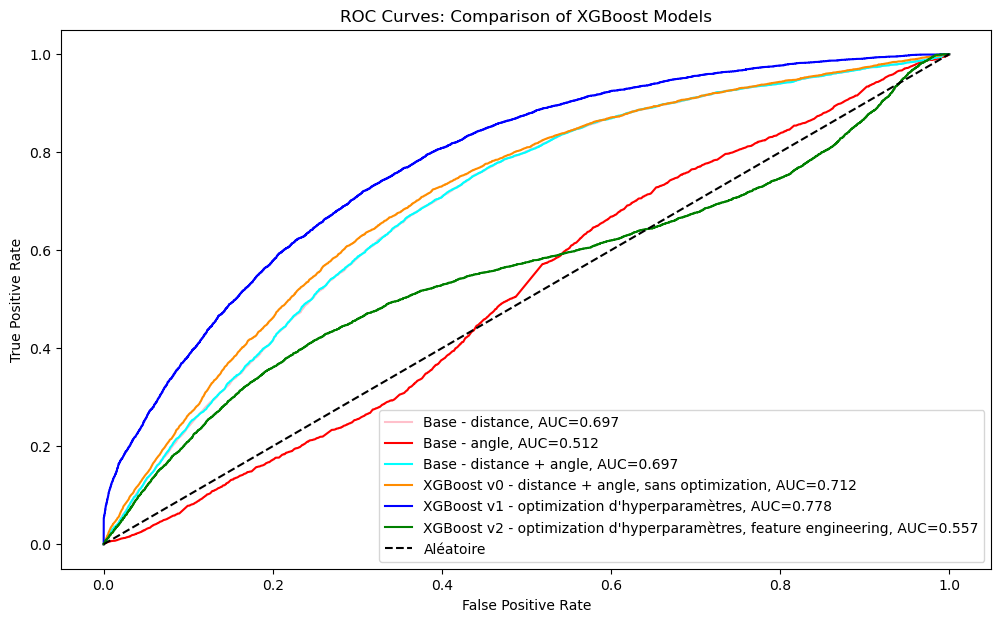

In [ ]:
plt.figure(0).clf()
plt.figure(figsize=(12, 7))

fpr, tpr, thresh = metrics.roc_curve(results_base_distance_season['is_goal'], results_base_distance_season['goal_proba'])
auc = metrics.roc_auc_score(results_base_distance_season['is_goal'], results_base_distance_season['goal_proba'])
plt.plot(fpr, tpr, label="Base - distance, AUC=" + f"{auc:.3f}", color='pink')

fpr, tpr, thresh = metrics.roc_curve(results_base_angle_season['is_goal'], results_base_angle_season['goal_proba'])
auc = metrics.roc_auc_score(results_base_angle_season['is_goal'], results_base_angle_season['goal_proba'])
plt.plot(fpr, tpr, label="Base - angle, AUC=" + f"{auc:.3f}", color='red')

fpr, tpr, thresh = metrics.roc_curve(results_base_distance_angle_season['is_goal'], results_base_distance_angle_season['goal_proba'])
auc = metrics.roc_auc_score(results_base_distance_angle_season['is_goal'], results_base_distance_angle_season['goal_proba'])
plt.plot(fpr, tpr, label="Base - distance + angle, AUC=" + f"{auc:.3f}", color='cyan')

fpr, tpr, thresh = metrics.roc_curve(results_xgboost_v1_season['is_goal'], results_xgboost_v1_season['goal_proba'])
auc = metrics.roc_auc_score(results_xgboost_v1_season['is_goal'], results_xgboost_v1_season['goal_proba'])
plt.plot(fpr, tpr, label="XGBoost v1 - optimization d'hyperparamètres, AUC=" + f"{auc:.3f}", color='blue')

# À rajouter les modèles avancés

plt.plot([0, 1], [0, 1], 'k--', label="Aléatoire")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC - Saison régulière")
plt.legend(loc="lower right")

plt.savefig(os.path.join(figpath_season, "roc.png"))
plt.show()

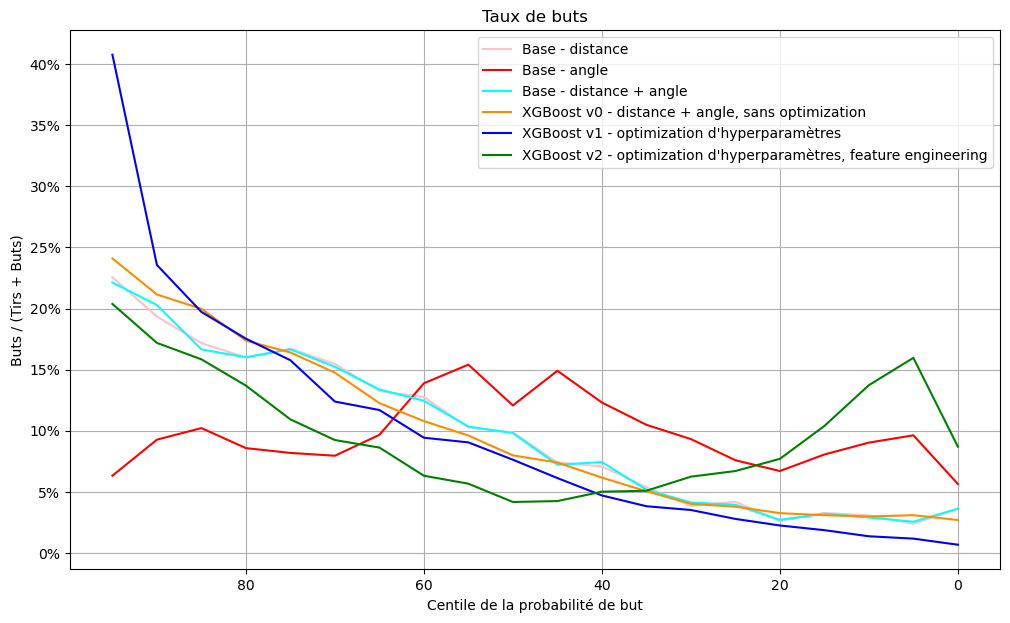

In [ ]:
def plot_goal_rates(results, label, color):
    gr_df = results.copy()
    percentile_bins = np.linspace(0, 1, 21)
    gr_df['percentile'] = pd.qcut(
        gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]
    )
    goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()
    plt.plot(percentile_bins[:-1], goal_rates, color=color, label=label)

plt.figure(figsize=(12, 7))

plot_goal_rates(results_base_distance_season, label="Base - distance", color='pink')
plot_goal_rates(results_base_angle_season, label="Base - angle", color='red')
plot_goal_rates(results_base_distance_angle_season, label="Base - distance + angle", color='cyan')
plot_goal_rates(results_xgboost_v1_season, label="XGBoost v1 - optimization d'hyperparamètres", color='blue')

# À rajouter les modèles avancés

plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts - Saison régulière')
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(figpath_season, "taux_de_buts.png"))
plt.show()

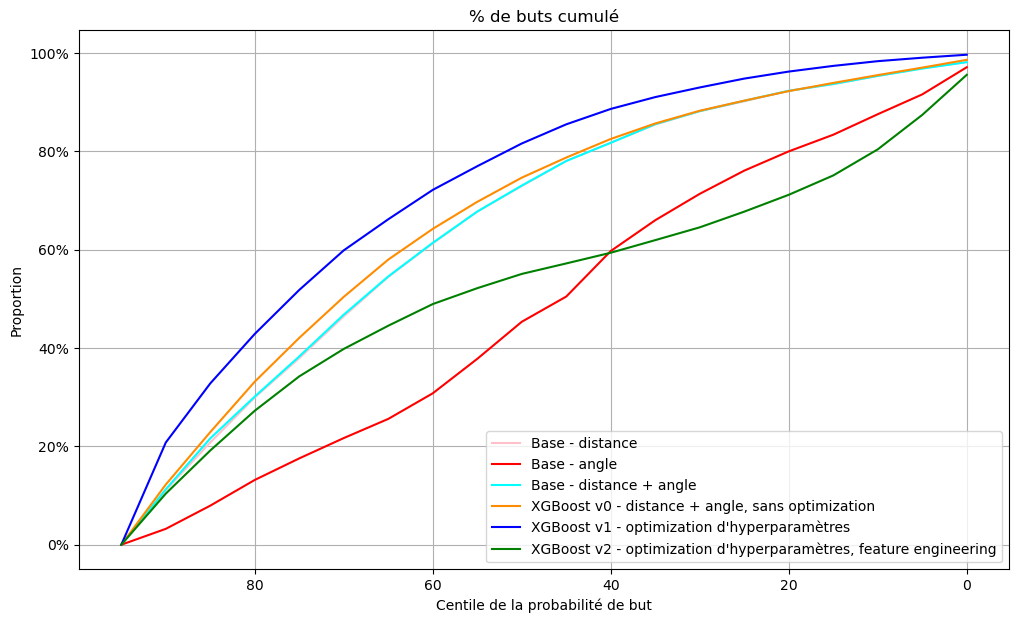

In [ ]:
def plot_cumulative_goals(results, label, color):
    cg_df = results.copy()
    percentile_bins = np.linspace(0, 1, 21)
    cg_df['percentile'] = pd.qcut(
        cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]
    )
    total_goals = cg_df['is_goal'].sum()
    goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_goals
    plt.plot(percentile_bins[:-1], goals_cums, color=color, label=label)

plt.figure(figsize=(12, 7))

plot_cumulative_goals(results_base_distance_season, label="Base - distance", color='pink')
plot_cumulative_goals(results_base_angle_season, label="Base - angle", color='red')
plot_cumulative_goals(results_base_distance_angle_season, label="Base - distance + angle", color='cyan')
plot_cumulative_goals(results_xgboost_v1_season, label="XGBoost v1 - optimization d'hyperparamètres", color='blue')

# À rajouter les modèles avancés

plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))

plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé - Saison régulière')

plt.legend()
plt.grid(True)

plt.savefig(os.path.join(figpath_season, "buts_cumul.png"))
plt.show()


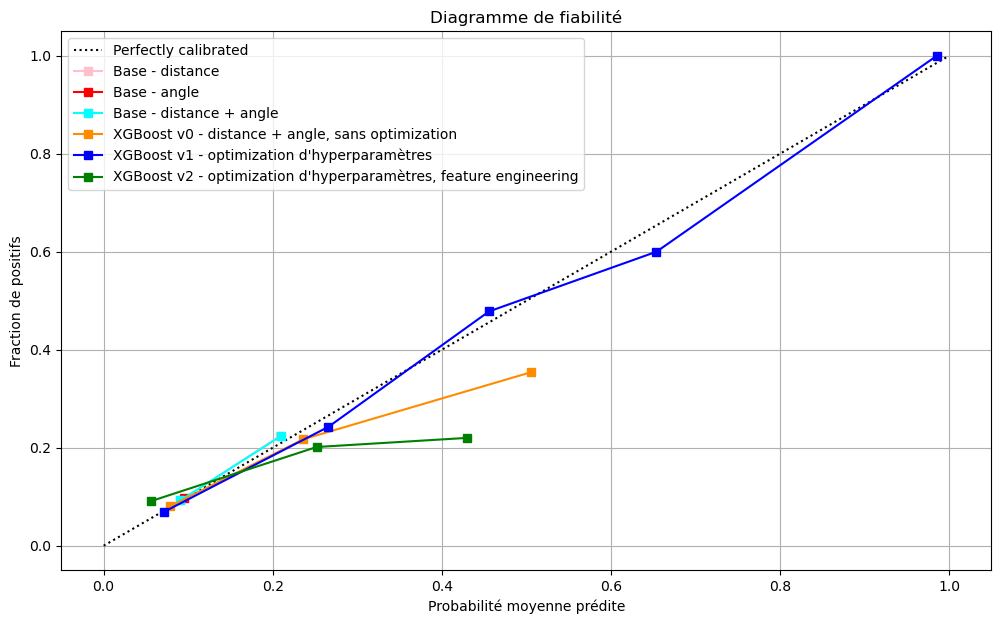

In [ ]:
def plot_calibration_curve(results, label, color):
    CalibrationDisplay.from_predictions(
        results['is_goal'],
        results['goal_proba'],
        name=label,
        color=color,
        ax=plt.gca()
    )

plt.figure(figsize=(12, 7))

plot_calibration_curve(results_base_distance_season, label="Base - distance", color='pink')
plot_calibration_curve(results_base_angle_season, label="Base - angle", color='red')
plot_calibration_curve(results_base_distance_angle_season, label="Base - distance + angle", color='cyan')
plot_calibration_curve(results_xgboost_v1_season, label="XGBoost v1 - optimization d'hyperparamètres", color='blue')

# À rajouter les modèles avancés

plt.title("Diagramme de fiabilité - Saison régulière")
plt.xlabel("Probabilité moyenne prédite")
plt.ylabel("Fraction de positifs")
plt.legend(loc="best")
plt.grid(True)

plt.savefig(os.path.join(figpath_season, "diag_fiab.png"))
plt.show()

### Playoffs

In [ ]:
figpath_playoffs = "../../figures/models/test_set/playoffs"
if not os.path.exists(figpath_playoffs):
    os.makedirs(figpath_playoffs)

In [ ]:
plt.figure(0).clf()
plt.figure(figsize=(12, 7))

fpr, tpr, thresh = metrics.roc_curve(results_base_distance_playoffs['is_goal'], results_base_distance_playoffs['goal_proba'])
auc = metrics.roc_auc_score(results_base_distance_playoffs['is_goal'], results_base_distance_playoffs['goal_proba'])
plt.plot(fpr, tpr, label="Base - distance, AUC=" + f"{auc:.3f}", color='pink')

fpr, tpr, thresh = metrics.roc_curve(results_base_angle_playoffs['is_goal'], results_base_angle_playoffs['goal_proba'])
auc = metrics.roc_auc_score(results_base_angle_playoffs['is_goal'], results_base_angle_playoffs['goal_proba'])
plt.plot(fpr, tpr, label="Base - angle, AUC=" + f"{auc:.3f}", color='red')

fpr, tpr, thresh = metrics.roc_curve(results_base_distance_angle_playoffs['is_goal'], results_base_distance_angle_playoffs['goal_proba'])
auc = metrics.roc_auc_score(results_base_distance_angle_playoffs['is_goal'], results_base_distance_angle_playoffs['goal_proba'])
plt.plot(fpr, tpr, label="Base - distance + angle, AUC=" + f"{auc:.3f}", color='cyan')

fpr, tpr, thresh = metrics.roc_curve(results_xgboost_v1_playoffs['is_goal'], results_xgboost_v1_playoffs['goal_proba'])
auc = metrics.roc_auc_score(results_xgboost_v1_playoffs['is_goal'], results_xgboost_v1_playoffs['goal_proba'])
plt.plot(fpr, tpr, label="XGBoost v1 - optimization d'hyperparamètres, AUC=" + f"{auc:.3f}", color='blue')

# À rajouter les modèles avancés

plt.plot([0, 1], [0, 1], 'k--', label="Aléatoire")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC - Playoffs")
plt.legend(loc="lower right")

plt.savefig(os.path.join(figpath_playoffs, "roc.png"))
plt.show()

In [ ]:
def plot_goal_rates(results, label, color):
    gr_df = results.copy()
    percentile_bins = np.linspace(0, 1, 21)
    gr_df['percentile'] = pd.qcut(
        gr_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]
    )
    goal_rates = gr_df.groupby('percentile', observed=False)['is_goal'].mean()
    plt.plot(percentile_bins[:-1], goal_rates, color=color, label=label)

plt.figure(figsize=(12, 7))

plot_goal_rates(results_base_distance_playoffs, label="Base - distance", color='pink')
plot_goal_rates(results_base_angle_playoffs, label="Base - angle", color='red')
plot_goal_rates(results_base_distance_angle_playoffs, label="Base - distance + angle", color='cyan')
plot_goal_rates(results_xgboost_v1_playoffs, label="XGBoost v1 - optimization d'hyperparamètres", color='blue')

# À rajouter les modèles avancés

plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))
plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Buts / (Tirs + Buts)')
plt.title('Taux de buts - Playoffs')
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(figpath_playoffs, "taux_de_buts.png"))
plt.show()

In [ ]:
def plot_cumulative_goals(results, label, color):
    cg_df = results.copy()
    percentile_bins = np.linspace(0, 1, 21)
    cg_df['percentile'] = pd.qcut(
        cg_df['goal_proba'], q=percentile_bins, labels=[p * 100 for p in percentile_bins[:-1]]
    )
    total_goals = cg_df['is_goal'].sum()
    goals_cums = 1 - cg_df.groupby('percentile', observed=False)['is_goal'].sum().cumsum() / total_goals
    plt.plot(percentile_bins[:-1], goals_cums, color=color, label=label)

plt.figure(figsize=(12, 7))

plot_cumulative_goals(results_base_distance_playoffs, label="Base - distance", color='pink')
plot_cumulative_goals(results_base_angle_playoffs, label="Base - angle", color='red')
plot_cumulative_goals(results_base_distance_angle_playoffs, label="Base - distance + angle", color='cyan')
plot_cumulative_goals(results_xgboost_v1_playoffs, label="XGBoost v1 - optimization d'hyperparamètres", color='blue')

# À rajouter les modèles avancés

plt.gca().invert_xaxis()
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x * 100:.0f}%'))

plt.xlabel('Centile de la probabilité de but')
plt.ylabel('Proportion')
plt.title('% de buts cumulé - Saison régulière')

plt.legend()
plt.grid(True)

plt.savefig(os.path.join(figpath_playoffs, "buts_cumul.png"))
plt.show()


In [ ]:
def plot_calibration_curve(results, label, color):
    CalibrationDisplay.from_predictions(
        results['is_goal'],
        results['goal_proba'],
        name=label,
        color=color,
        ax=plt.gca()
    )

plt.figure(figsize=(12, 7))

plot_calibration_curve(results_base_distance_playoffs, label="Base - distance", color='pink')
plot_calibration_curve(results_base_angle_playoffs, label="Base - angle", color='red')
plot_calibration_curve(results_base_distance_angle_playoffs, label="Base - distance + angle", color='cyan')
plot_calibration_curve(results_xgboost_v1_playoffs, label="XGBoost v1 - optimization d'hyperparamètres", color='blue')

# À rajouter les modèles avancés

plt.title("Diagramme de fiabilité - Saison régulière")
plt.xlabel("Probabilité moyenne prédite")
plt.ylabel("Fraction de positifs")
plt.legend(loc="best")
plt.grid(True)

plt.savefig(os.path.join(figpath_playoffs, "diag_fiab.png"))
plt.show()